In [237]:
import pandas as pd
from pandas import DataFrame as DF
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

from IPython.html.widgets import interact, interactive, fixed
from IPython.display import display
import IPython.html.widgets as widgets
from IPython.utils.traitlets import link as traitlink

execfile('../src/moldev_utils.py')

from toolz import pipe,thread_first, curry, frequencies

# How do parameters vary with drug dose?

In [146]:
def parse_condition(x):
    words = x.split(' ')
    if len(words) == 2: 
        return dict(Base = words[0],
                    Dose = 0,
                    Unit = '',
                    Drug = words[-1])
    elif len(words) == 3:
        return dict(Base = words[0],
                    Dose = float(words[1].rstrip('%')),
                    Unit = '%',
                    Drug = words[2])
    elif len(words) == 4: 
        return dict(Base = words[0],
                    Dose = float(words[1]),
                    Unit = words[2],
                    Drug = words[3])
    elif len(words) == 5:
        return dict(Base = words[0],
                    Dose = float(words[1]),
                    Unit = words[2],
                    Drug = " ".join(words[3:]))
    else:
        raise Exception("don't know how to parse condition: {}".format(x))

In [147]:
def add_condition_cols(df):
    new_df = df.copy()
    for field in ['Base','Dose','Unit','Drug']:
        new_df[field] = df['Condition'].map(lambda c: parse_condition(c)[field])
    return move_columns(new_df,[['Base',2],['Dose',3],['Unit',4],['Drug',5]])

In [290]:
data = thread_first('../output/condition_summary.csv',
                    pd.read_csv,
                    lambda df: df[df['Function'] == 'mean'],
                    add_condition_cols)

error = thread_first('../output/condition_summary.csv',
                    pd.read_csv,
                    lambda df: df[df['Function'] == 'sem'],
                    add_condition_cols)

In [291]:
def filter_rows(df,col,val):
    if type(val) == list:
        return df[df[col].isin(val)]
    else:
        return df[df[col] == val]

In [259]:
def get_drugs_with_multiple_doses(df):
    return pipe(df.groupby('Drug').count()['Dose'],
                lambda x: x[x>1].index.values,
                list)

In [402]:
def label(x,y,t,fontsize=12):
    plt.xlabel(x,fontsize=fontsize)
    plt.ylabel(y,fontsize=fontsize)
    plt.title(t,fontsize=fontsize)

In [403]:
def dose_plot(df,err,cols,scale='linear'):
    n_rows = int(np.ceil(len(cols)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for col,sub in zip(cols,subs):
        plt.subplot(sub)
        for base in df['Base'].unique():
            for drug in get_drugs_with_multiple_doses(filter_rows(df,'Base',base)):
                data = thread_first(df,
                                    (filter_rows,'Drug',drug),
                                    (filter_rows,'Base',base),
                                    (DF.sort, 'Dose'))
                error = thread_first(err,
                                     (filter_rows,'Drug',drug),
                                     (filter_rows,'Base',base),
                                     (DF.sort, 'Dose'))
                if scale == 'linear':
                    plt.errorbar(data['Dose'],data[col],yerr=error[col])
                    title = "{} vs. Dose".format(col)
                else: 
                    plt.errorbar(data['Dose'],data[col],yerr=error[col])
                    plt.xscale('log')
                    title = "{} vs. Dose (Log Scale)".format(col)
                    plt.xticks(data['Dose'].values,data['Dose'].values)
                    plt.xlim(0.06,15)
                label('Dose ({})'.format(data.Unit.values[0]), col,title,fontsize = 15)

                plt.legend(df['Base'].unique(), loc = 0)

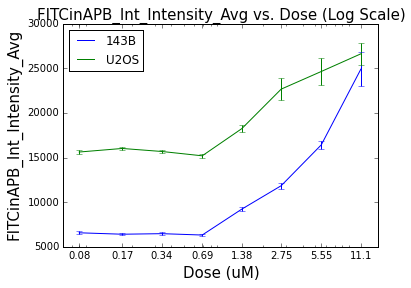

In [404]:
interact(dose_plot, 
         s = (0,0.5,0.03),
         scale = widgets.ToggleButtons(options=['linear','log']), 
         df = fixed(data),
         err = fixed(error),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= [col for col in data.columns.values.tolist() if col not in ['Condition','Function','Base','Dose','Unit','Drug']],
                              height=250));